<a href="https://www.kaggle.com/code/mdsayebgub/ucf-50-human-activity-recognition-resnet50-lstm?scriptVersionId=248180256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="border:5px solid #85929e; border-radius:10px; padding:5px; padding-top:20px; background-color:#2c2c2c">
<img src="https://blog.subharti.org/wp-content/uploads/2024/05/Blog-Featured-image.jpg" style="width: 700px; display: block; margin:auto; border-radius:20px; ">
<p style="margin-top:20px;font-size: 35px; text-align: center; color: #1baad4 ; font-weight: bold; font-family:harlow solid italic;">Human Activity Recognition🏃</p></div>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,classification_report
from tensorflow.keras.layers import TimeDistributed,Dropout,Flatten,Dense,LSTM
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
import random
import warnings
warnings.filterwarnings('ignore')

# **Working on data**

> **In first we choose classes what we want our model to classify**

In [2]:
classes = ["Basketball","Diving","HorseRace","JumpRope","VolleyballSpiking"]

## **Visualize our choosen classes**

In [ ]:
plt.figure(figsize=(10, 10))
for counter,selected_class_name in enumerate(classes,1):
    video_files_names_list=os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}')
    selected_video_file_name=random.choice(video_files_names_list)
    video_reader=cv2.VideoCapture(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}/{selected_video_file_name}')
    _,bgr_frame=video_reader.read()
    bgr_frame=cv2.resize(bgr_frame,(224,224))
    video_reader.release()
    rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,counter)
    plt.imshow(rgb_frame)
    cv2.putText(rgb_frame,selected_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    plt.subplot(2,3,counter)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Creating DataSet and preprocessing**

> **Choose number of features**

In [4]:
sequnce_length=15

> **Function to extract frames from videos**

In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/15), 1)
    for frame_counter in range(15):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        succes, frame = video_reader.read()
        if not succes:
            break
        frames_list.append(frame)
    video_reader.release()

    return frames_list


> **Function to create dataset from video frames and labels**

In [6]:
def create_dataset():
    features = []
    labels = []
    for class_name in classes:
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name))
        for file_name in files_list:
            video_file_path = os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == sequnce_length:
                features.append(frames)
                labels.append(class_name)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels

In [7]:
features,labels=create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: Diving
Extracting Data of Class: HorseRace
Extracting Data of Class: JumpRope
Extracting Data of Class: VolleyballSpiking


## **Resize Images**

In [8]:
X=[]
for feature_list in features:
    x=[]
    for feature in feature_list:
        feature = cv2.resize(feature, (224, 224))
        x.append(feature)
        del feature
    x=np.array(x)
    X.append(x)
    del x
X=np.array(X)

In [9]:
print("Before",features.shape)
print("After",X.shape)

Before (681, 15, 240, 320, 3)
After (681, 15, 224, 224, 3)


## **Standardization**

In [10]:
X = X.astype(np.float32) 
mean = np.mean(X)
X -= mean
std = np.std(X, axis=0)
X /= std

## **Encode Labels**

In [11]:
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
for label in np.unique(labels):
    print(f"{encoder.transform([label])[0]} : {label}")

0 : Basketball
1 : Diving
2 : HorseRace
3 : JumpRope
4 : VolleyballSpiking


## **Spliting**

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## **Delete variables to free space in ram**

In [13]:
del X,y,features,labels

# **Work on Model**

## **Training Model**

> **Finetuning ResNet50**

In [14]:
resnet=ResNet50(weights="imagenet",include_top=False,input_shape=(224,224,3))
for l in resnet.layers:
    l.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


> **Build Model**

In [15]:
model = Sequential([
    TimeDistributed(resnet,input_shape=(15,224,224,3),name="ResNet"),
    TimeDistributed(Flatten(),name="Flatten"),
    LSTM(180,activation="relu"),
    Dropout(0.2),
    Dense(5,activation="softmax")
])

In [16]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ResNet (TimeDistributed)        │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (TimeDistributed)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

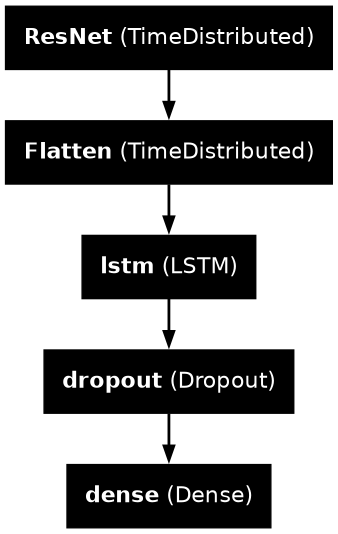

In [17]:
plot_model(model,show_layer_names=True,dpi=100)

> **Training**

In [18]:
es=EarlyStopping("val_loss",mode="min",verbose=1,patience=7,restore_best_weights=True)
history=model.fit(x_train,y_train,epochs=50,batch_size=5,validation_split=0.2,callbacks=[es])

Epoch 1/50


I0000 00:00:1751260975.677632    2849 service.cc:145] XLA service 0x7f2e2028bab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751260975.677739    2849 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751261005.255318    2849 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 916ms/step - accuracy: 0.2217 - loss: 1019.6014 - val_accuracy: 0.2110 - val_loss: 1039.6047
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 313ms/step - accuracy: 0.1966 - loss: 1203.9518 - val_accuracy: 0.1927 - val_loss: 260.2428
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 313ms/step - accuracy: 0.2064 - loss: 628.7780 - val_accuracy: 0.2936 - val_loss: 93.4694
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.2622 - loss: 198.9538 - val_accuracy: 0.2110 - val_loss: 162.4571
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.2381 - loss: 208.9888 - val_accuracy: 0.2202 - val_loss: 112.6793
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 313ms/step - accuracy: 0.3465 - loss: 79.7507 - val_accuracy: 0.2661 - val_loss: 35.7954
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 313ms/step - accuracy: 0.3008 - loss: 50.1711 - val_accuracy: 0.2844 - val_loss: 20.2608
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.4694 - loss: 2

## **Model Evaluation**

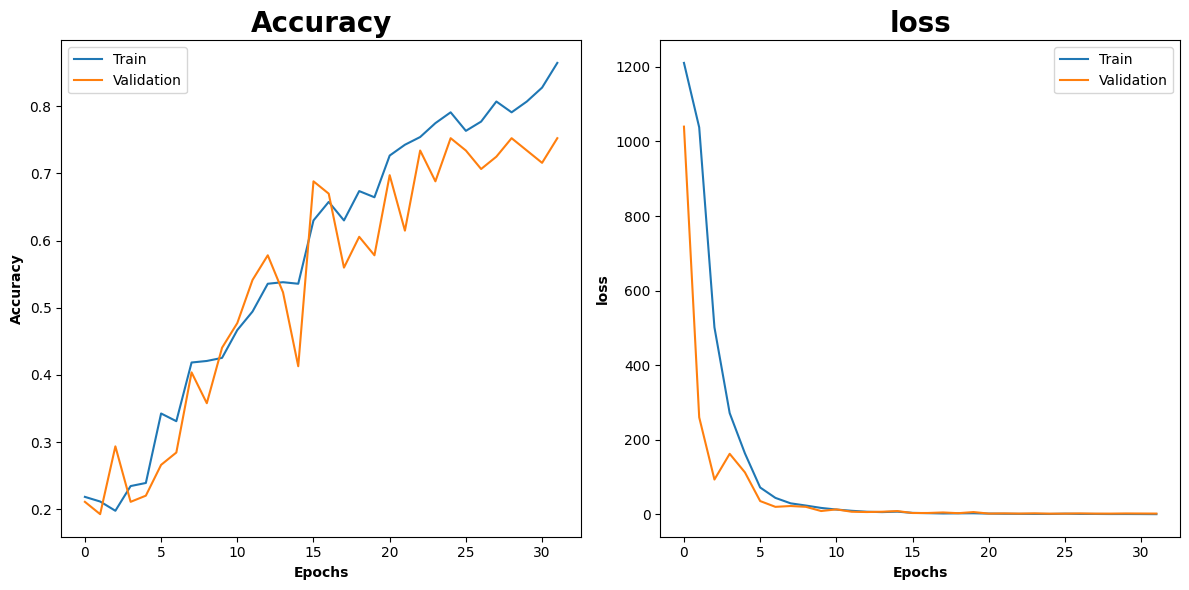

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Accuracy",weight="bold",fontsize=20)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs",weight="bold")
plt.ylabel("Accuracy",weight="bold")
plt.subplot(1,2,2)
plt.title("loss",weight="bold",fontsize=20)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs",weight="bold")
plt.ylabel("loss",weight="bold")
plt.tight_layout()
plt.show()

In [20]:
prediction = model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step 


In [21]:
y_hat = []
for p in prediction:
    res = np.argmax(p)
    y_hat.append(res)
y_hat = np.array(y_hat)


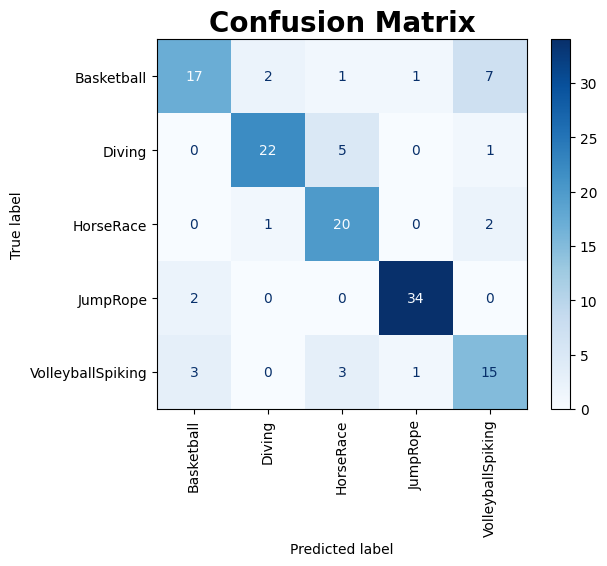

In [22]:
matrix=confusion_matrix(y_test,y_hat)
figure=ConfusionMatrixDisplay(matrix,
                              display_labels=["Basketball",
                                              "Diving",
                                              "HorseRace",
                                              "JumpRope",
                                              "VolleyballSpiking"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix",fontsize=20,weight="bold")
plt.xticks(rotation=90)
plt.show()

In [23]:
report=classification_report(y_test,y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        28
           1       0.88      0.79      0.83        28
           2       0.69      0.87      0.77        23
           3       0.94      0.94      0.94        36
           4       0.60      0.68      0.64        22

    accuracy                           0.79       137
   macro avg       0.78      0.78      0.77       137
weighted avg       0.80      0.79      0.79       137



## **Save Model**

In [24]:
model.save("human_activitV1.h5")

# **Prediction**

In [25]:
def Human_activity_prediction(video_path , mean , std):
    frames = frames_extraction(video_path)
    if len(frames) != 15:
        raise ValueError(f"Expected {15} frames but got {len(frames)} frames from the video.")
    preprocessed_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (224, 224))
        preprocessed_frames.append(resized_frame)
    
    preprocessed_frames= (np.array(preprocessed_frames)).astype(np.float32)
    preprocessed_frames -= mean
    preprocessed_frames /= std
    
    
    preprocessed_frames = np.expand_dims(preprocessed_frames, axis=0)
    
    predicted_probabilities = model.predict(preprocessed_frames)[0]
    print(predicted_probabilities)
    predicted_label = np.argmax(predicted_probabilities)
    predicted_class = encoder.inverse_transform([predicted_label])[0]
    
    print(predicted_class)

In [26]:
path="/kaggle/input/realistic-action-recognition-ucf50/UCF50/Basketball/v_Basketball_g02_c02.avi"
Human_activity_prediction(path,
                         mean,std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
[7.9667073e-01 1.8089054e-04 4.3549264e-04 9.5771984e-06 2.0270328e-01]
Basketball


In [27]:
path="/kaggle/input/realistic-action-recognition-ucf50/UCF50/HorseRace/v_HorseRace_g02_c01.avi"
Human_activity_prediction(path,
                         mean,std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[9.7745773e-23 1.5902368e-14 1.0000000e+00 0.0000000e+00 3.4369015e-36]
HorseRace


<div style="border:5px solid #85929e; border-radius:10px; padding:110px; background-color:#2c2c2c">

<p style="font-size: 50px; text-align: center; color: #1baad4 ; font-family:freestyle script; font-weight: bold;">Thanks & Waiting for your feedback🖤<br>Follow for more notebooks➕</p>
</div>